<a href="https://colab.research.google.com/github/mayourbukhari/AI-and-ML-Resources/blob/main/AI_BASED_IDENTIFICATION_OF_FINANCIAL_NEEDS_USING_DEMOGRAPHIC%2C_ECONOMIC%2C_AND_SATELLITE_IMAGERY_DATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to the Project: AI-Based Financial Needs Prediction

## Project Overview
This project, titled **"AI-Based Financial Needs Prediction"**, leverages advanced machine learning techniques to predict financial needs based on economic indicators and satellite imagery. It integrates data from the World Bank (e.g., population, GDP, inflation, income per capita) with Normalized Difference Vegetation Index (NDVI) derived from Sentinel-2 satellite images to model transaction amounts over time. The solution employs two neural network architectures—LSTM and Transformer—to capture temporal patterns and provide accurate predictions. The project culminates in an interactive Streamlit dashboard, deployed via ngrok, allowing users to input data and visualize predictions.

## Developer Details
- **Name**: Syed Mohsin Bukhari
- **Affiliation**: Lovely Professional University, Punjab
- **LinkedIn**: [https://www.linkedin.com/in/syed-mohsin-bukhari/](https://www.linkedin.com/in/syed-mohsin-bukhari/)
- **Contact**: Available via LinkedIn for collaboration or feedback.

## Purpose
The goal is to demonstrate how AI can combine diverse data sources (economic and environmental) to support financial planning, particularly in agricultural contexts. This notebook guides you through data collection, model training, and deployment, with all code optimized for Google Colab.

**Action**: Read this introduction, then proceed to Cell 1 to install the required libraries and begin the project.

# Cell 1: Install Libraries

This cell installs all the required Python libraries needed for the project using the `!pip install` command in Google Colab. The `-q` flag suppresses detailed output to keep the notebook clean. The libraries include:

- `tensorflow`: For building and training neural network models (LSTM and Transformer).
- `scikit-learn`: For data preprocessing and evaluation metrics.
- `pandas` and `numpy`: For data manipulation and numerical operations.
- `matplotlib`: For plotting training history and evaluation results.
- `streamlit`: For creating the interactive web dashboard.
- `pyngrok`: To expose the Streamlit app publicly via ngrok.
- `wbdata`: To fetch World Bank economic data.
- `rasterio`: To process Sentinel-2 satellite imagery.

**Action**: Run this cell first to ensure all dependencies are installed before proceeding.

In [1]:
# Install required libraries in Colab
!pip install tensorflow scikit-learn pandas numpy matplotlib streamlit pyngrok wbdata rasterio

# Cell 2: Import Libraries and Set Seeds

This cell imports all the necessary Python libraries and sets random seeds for reproducibility. The imports include:

- Core libraries (`numpy`, `pandas`, `matplotlib`) for data handling and visualization.
- Machine learning tools (`sklearn`, `tensorflow`) for modeling.
- Streamlit and ngrok for the dashboard.
- Rasterio for satellite image processing.
- Colab-specific `files` for uploading data.

The `np.random.seed(42)` and `tf.random.set_seed(42)` ensure consistent random number generation across runs, which is crucial for repeatable model training results.



In [2]:
# Import libraries
import numpy as np
import pandas as pd
import wbdata
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error, explained_variance_score
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import streamlit as st
from pyngrok import ngrok
import os
import time
import subprocess
import rasterio
from google.colab import files

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Cell 3: Define Data Fetching and Processing Functions

This cell defines three key functions for data handling:

- `fetch_real_world_data()`: Retrieves economic indicators (population, GDP, inflation rate, income per capita) from the World Bank API for India, adds a synthetic transaction amount and farming cycle phase, and returns a cleaned DataFrame.
- `process_satellite_image()`: Processes a Sentinel-2 `.tif` image to calculate the Normalized Difference Vegetation Index (NDVI) using NIR and Red bands. It includes debugging prints for band indices and shapes.
- `preprocess_data()`: Preprocesses the DataFrame by converting dates, interpolating missing values, adding derived features (spending trend, income seasonal), incorporating NDVI from satellite data (if provided), scaling numerical columns, and creating sequence data for time series modeling.



In [3]:
# --- Fetch Real-World Data ---
def fetch_real_world_data():
    indicators = {
        "SP.POP.TOTL": "population",
        "NY.GDP.MKTP.CD": "gdp",
        "FP.CPI.TOTL.ZG": "inflation_rate",
        "NY.GNP.PCAP.CD": "income_per_capita"
    }
    wb_df = wbdata.get_dataframe(indicators, country="IND").reset_index().sort_values("date").dropna()
    years = wb_df["date"].astype(int)
    farming_cycle = pd.Series(np.sin(2 * np.pi * (years % 1)), index=wb_df.index)
    wb_df["farming_cycle_phase"] = pd.cut(farming_cycle, bins=[-np.inf, -0.5, 0.5, np.inf],
                                          labels=["Sowing", "Growing", "Harvest"])
    wb_df["transaction_amount"] = wb_df["gdp"] * np.random.uniform(0.01, 0.05, len(wb_df))
    df = wb_df[["date", "transaction_amount", "population", "income_per_capita",
                "inflation_rate", "farming_cycle_phase"]].rename(columns={"population": "age"})
    return df

# --- Process Sentinel-2 Imagery ---
def process_satellite_image(image_path):
    """
    Extract NDVI from a Sentinel-2 image.
    Handles potential band indexing errors.
    """
    with rasterio.open(image_path) as src:
        print("Available bands:", src.indexes)
        nir_band = src.indexes[-1]  # Assuming NIR is the last band
        red_band = src.indexes[-2]  # Assuming Red is the second-to-last band
        nir = src.read(nir_band).astype(float)
        red = src.read(red_band).astype(float)
        print("Shape of NIR:", nir.shape)
        print("Shape of Red:", red.shape)
        ndvi = np.where((nir + red) != 0, (nir - red) / (nir + red), 0)
        return np.nanmean(ndvi)

# --- Data Preprocessing Module ---
def preprocess_data(df, image_path=None):
    df["date"] = pd.to_datetime(df["date"])
    df = df.set_index("date")
    df = df.infer_objects(copy=False)
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].interpolate(method='linear', limit_direction='forward').fillna(0)

    cycle_mapping = {"Sowing": 0, "Growing": np.pi / 2, "Harvest": np.pi}
    df["farming_cycle_numeric"] = df["farming_cycle_phase"].map(cycle_mapping).astype(np.float32).fillna(0)

    df["spending_trend"] = df["transaction_amount"].rolling(window=3, min_periods=1).mean()
    df["income_seasonal"] = df["income_per_capita"] * (1 + 0.2 * np.sin(df["farming_cycle_numeric"]))

    if image_path:
        crop_health = process_satellite_image(image_path)
        df["crop_health"] = crop_health
    else:
        df["crop_health"] = 0.5

    scaler = MinMaxScaler()
    numerical_cols = ["transaction_amount", "age", "income_per_capita", "inflation_rate",
                      "spending_trend", "income_seasonal", "crop_health"]
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

    df = pd.get_dummies(df, columns=["farming_cycle_phase"], prefix="cycle")
    df = df.drop(columns=["farming_cycle_numeric"])
    df = df.astype(np.float32)

    X, y = [], []
    sequence_length = 10
    for i in range(len(df) - sequence_length):
        X.append(df.iloc[i:i+sequence_length].values)
        y.append(df["transaction_amount"].iloc[i+sequence_length])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32), scaler

# Cell 4: Define Model Architectures and Training Functions

This cell defines the model architectures and training utilities:

- `build_lstm_model()`: Constructs a Sequential LSTM model with two LSTM layers, Dropout for regularization, and Dense layers for output, compiled with the Adam optimizer and MSE loss.
- `TransformerBlock`: A custom Keras layer implementing a Transformer block with multi-head attention, feed-forward network, layer normalization, and dropout.
- `build_transformer_model()`: Builds a Transformer model using the `TransformerBlock`, followed by global pooling and Dense layers, compiled similarly to the LSTM.
- `train_model()`: Trains a model on training data with validation, returning the training history.
- `evaluate_model()`: Evaluates a model on test data, computing metrics (MSE, RMSE, MAE, MAPE, R², explained variance) and plotting actual vs. predicted values.

In [18]:
# --- LSTM Model ---
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(16, activation="relu"),
        Dense(1, activation="linear")
    ])
    model.compile(optimizer="adam", loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanAbsoluteError()])
    return model

# --- Transformer Model ---
# Import necessary modules
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Instead of using @keras.saving.register_keras_serializable(),
# directly subclass tf.keras.layers.Layer for custom layers:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, trainable=True, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim)])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

def build_transformer_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    x = TransformerBlock(embed_dim=input_shape[-1], num_heads=2, ff_dim=32)(inputs, training=False)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(16, activation="relu")(x)
    outputs = layers.Dense(1, activation="linear")(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanAbsoluteError()])
    return model

# --- Training Function ---
def train_model(model, X_train, y_train, X_val, y_val, epochs=20, batch_size=32):
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=epochs, batch_size=batch_size, verbose=1)
    return history

# --- Enhanced Evaluation Function ---
def evaluate_model(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = model.evaluate(X_test, y_test, verbose=0)[1]
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    r2 = r2_score(y_test, y_pred)
    explained_var = explained_variance_score(y_test, y_pred)

    print(f"\n{model_name} Evaluation:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    print(f"R² Score: {r2:.4f}")
    print(f"Explained Variance Score: {explained_var:.4f}")

    plt.figure(figsize=(10, 6))
    plt.plot(y_test[:50], label="Actual", marker='o')
    plt.plot(y_pred[:50], label="Predicted", marker='x')
    plt.title(f"{model_name}: Actual vs Predicted")
    plt.xlabel("Sample")
    plt.ylabel("Transaction Amount (Normalized)")
    plt.legend()
    plt.show()

    return mse, rmse, mae, mape, r2, explained_var

# Cell 5: Main Execution and Data Preparation

This cell executes the data pipeline:

- Fetches real-world data using `fetch_real_world_data()`.
- Prompts the user to upload a Sentinel-2 Level-2A `.tif` image via `files.upload()` (optional).
- Preprocesses the data with `preprocess_data()`, incorporating the satellite image if uploaded.
- Splits the data into training (70%), validation (15%), and test (15%) sets using `train_test_split`.



In [19]:
# --- Main Execution ---
# Fetch real-world data
data = fetch_real_world_data()

# Use Sentinel-2 dataset
print("Please upload a Sentinel-2 Level-2A .tif image from Copernicus Open Access Hub.")
print("Go to https://scihub.copernicus.eu/, search for Sentinel-2 data (e.g., over India), and download a Level-2A product.")
uploaded = files.upload()
image_path = list(uploaded.keys())[0] if uploaded else None

# Preprocess data with Sentinel-2 image
X, y, scaler = preprocess_data(data, image_path)

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

Please upload a Sentinel-2 Level-2A .tif image from Copernicus Open Access Hub.
Go to https://scihub.copernicus.eu/, search for Sentinel-2 data (e.g., over India), and download a Level-2A product.


Saving 2023-06-01-00_00_2023-06-01-23_59_Sentinel-2_L2A_NDVI.tiff to 2023-06-01-00_00_2023-06-01-23_59_Sentinel-2_L2A_NDVI (1).tiff
Available bands: (1, 2, 3)
Shape of NIR: (1903, 2500)
Shape of Red: (1903, 2500)


# Cell 6: Train and Evaluate Models

This cell trains and evaluates the models:

- Builds and trains the LSTM model with `build_lstm_model()` and `train_model()`.
- Builds and trains the Transformer model with `build_transformer_model()` and `train_model()`.
- Saves the trained Transformer model to Google Drive at `/content/drive/MyDrive/AI-Based Financial Needs Prediction/transformer_model.h5`.
- Evaluates both models on the test set using `evaluate_model()`, printing metrics and plotting actual vs. predicted values for the first 50 samples.
- Plots the training and validation loss for both models over epochs.



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.2463 - mean_absolute_error: 0.3755 - val_loss: 0.2309 - val_mean_absolute_error: 0.3899
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.2140 - mean_absolute_error: 0.3353 - val_loss: 0.1962 - val_mean_absolute_error: 0.3507
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.1814 - mean_absolute_error: 0.2949 - val_loss: 0.1677 - val_mean_absolute_error: 0.3140
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.1591 - mean_absolute_error: 0.2608 - val_loss: 0.1474 - val_mean_absolute_error: 0.2914
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.1435 - mean_absolute_error: 0.2431 - val_loss: 0.1306 - val_mean_absolute_error: 0.2718
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.1272 - mean_absolute_error: 0.2200 - val_loss: 0.1138 - val_mean_absolute_error: 0.2502
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.1162 - mean_absolute_error: 0.2195 - val_loss: 0.0979 -

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step

LSTM Model Evaluation:
Mean Squared Error (MSE): 0.0529
Root Mean Squared Error (RMSE): 0.2300
Mean Absolute Error (MAE): 0.2239
Mean Absolute Percentage Error (MAPE): 498.72%
R² Score: -1.1143
Explained Variance Score: 0.8886


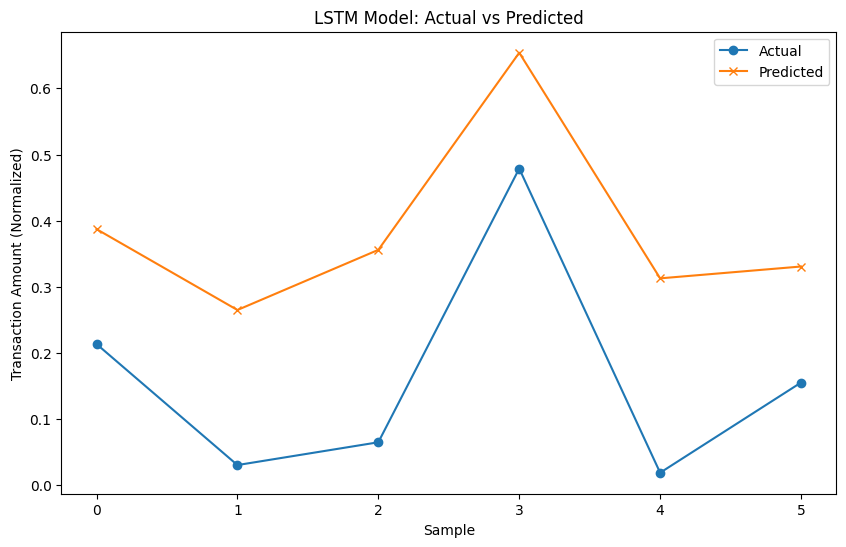

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step

Transformer Model Evaluation:
Mean Squared Error (MSE): 0.0895
Root Mean Squared Error (RMSE): 0.2992
Mean Absolute Error (MAE): 0.2306
Mean Absolute Percentage Error (MAPE): 247.82%
R² Score: -2.5780
Explained Variance Score: -0.5918


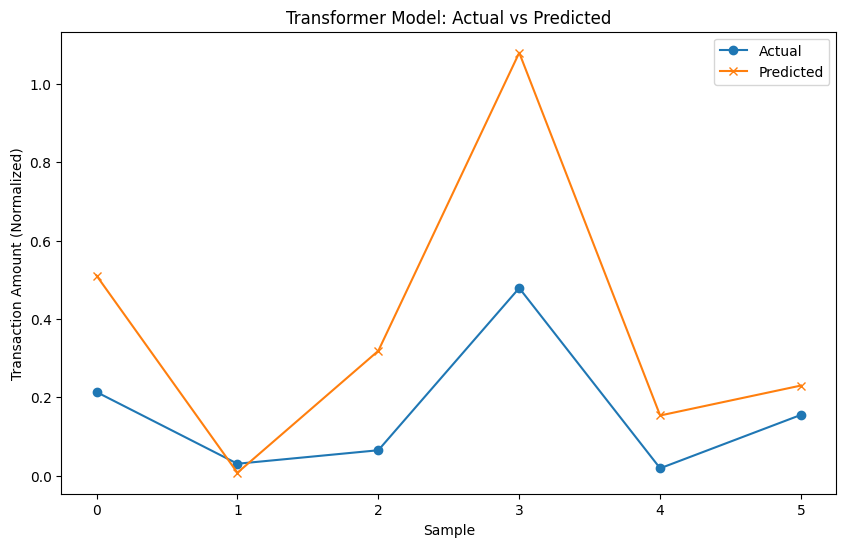

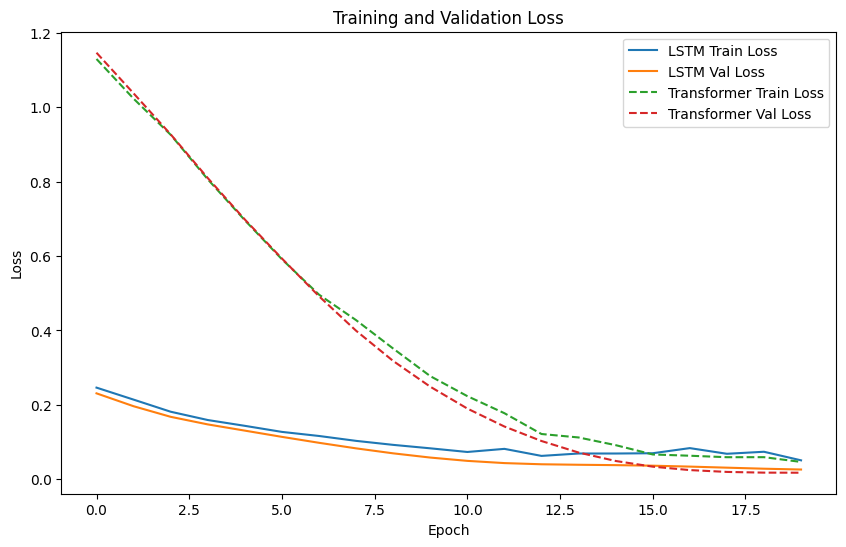

In [20]:
# Build and train LSTM model
lstm_model = build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]))
lstm_history = train_model(lstm_model, X_train, y_train, X_val, y_val)

# Build and train Transformer model
transformer_model = build_transformer_model(input_shape=(X_train.shape[1], X_train.shape[2]))
transformer_history = train_model(transformer_model, X_train, y_train, X_val, y_val)

# Save the Transformer model
transformer_model.save('/content/drive/MyDrive/AI-Based Financial Needs Prediction/transformer_model.h5')

# Evaluate models
lstm_metrics = evaluate_model(lstm_model, X_test, y_test, "LSTM Model")
transformer_metrics = evaluate_model(transformer_model, X_test, y_test, "Transformer Model")

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(lstm_history.history['loss'], label='LSTM Train Loss')
plt.plot(lstm_history.history['val_loss'], label='LSTM Val Loss')
plt.plot(transformer_history.history['loss'], label='Transformer Train Loss', linestyle='--')
plt.plot(transformer_history.history['val_loss'], label='Transformer Val Loss', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Cell 7: Launch Streamlit Dashboard

This cell sets up and launches the Streamlit dashboard:

- Defines the `dashboard_code` string, which includes:
  - A `TransformerBlock` class matching the training definition.
  - Model loading with error handling.
  - `process_satellite_image()` and `preprocess_data()` for prediction.
  - A styled Streamlit app with custom CSS, sidebar, input form, prediction logic, and footer.
- Writes the dashboard code to `/content/drive/MyDrive/AI-Based Financial Needs Prediction/app.py`.
- Starts a Streamlit server on port 8501 using `subprocess.Popen`.
- Configures ngrok with your auth token (replace `YOUR_NGROK_AUTH_TOKEN`) to provide a public URL.
- Keeps the notebook running until interrupted.



In [27]:
# --- Streamlit Dashboard Code ---
dashboard_code = """
import streamlit as st
import numpy as np
import pandas as pd
import tensorflow as tf
import keras  # Add this import to resolve the NameError
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
import rasterio

# Define TransformerBlock
@keras.saving.register_keras_serializable()  # Register the custom layer
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, trainable=True, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim)])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Load the model with custom objects
try:
    model = tf.keras.models.load_model(
        '/content/drive/MyDrive/AI-Based Financial Needs Prediction/transformer_model.h5',
        custom_objects={'TransformerBlock': TransformerBlock}
    )
except Exception as e:
    st.error(f"Error loading model: {str(e)}")
    st.stop()

# Process satellite imagery
def process_satellite_image(image_path):
    with rasterio.open(image_path) as src:
        nir = src.read(8).astype(float)
        red = src.read(4).astype(float)
        ndvi = np.where((nir + red) != 0, (nir - red) / (nir + red), 0)
        return np.nanmean(ndvi)

# Preprocessing function
def preprocess_data(df, image_path=None):
    df = df.infer_objects(copy=False)
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].interpolate(method='linear', limit_direction='forward').fillna(0)
    cycle_mapping = {'Sowing': 0, 'Growing': np.pi / 2, 'Harvest': np.pi}
    df['farming_cycle_numeric'] = df['farming_cycle_phase'].map(cycle_mapping).astype(np.float32).fillna(0)
    df['spending_trend'] = df['transaction_amount'].rolling(window=3, min_periods=1).mean()
    df['income_seasonal'] = df['income_per_capita'] * (1 + 0.2 * np.sin(df['farming_cycle_numeric']))
    if image_path:
        crop_health = process_satellite_image(image_path)
        df['crop_health'] = crop_health
    else:
        df['crop_health'] = 0.5
    scaler = MinMaxScaler()
    numerical_cols = ['transaction_amount', 'age', 'income_per_capita', 'inflation_rate', 'spending_trend', 'income_seasonal', 'crop_health']
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
    df = pd.get_dummies(df, columns=['farming_cycle_phase'], prefix='cycle')
    df = df.drop(columns=['farming_cycle_numeric'])
    df = df.astype(np.float32)
    X = []
    sequence_length = 10
    for i in range(len(df) - sequence_length + 1):
        X.append(df.iloc[i:i+sequence_length].values)
    return np.array(X, dtype=np.float32), scaler

# Custom CSS
st.markdown('''
    <style>
    .title { color: #2c3e50; font-size: 36px; font-weight: bold; text-align: center; margin-bottom: 10px; }
    .subtitle { color: #34495e; font-size: 18px; text-align: center; margin-bottom: 20px; }
    .footer { color: #7f8c8d; font-size: 14px; text-align: center; margin-top: 30px; }
    .input-box { background-color: #ecf0f1; padding: 15px; border-radius: 10px; box-shadow: 0 4px 6px rgba(0,0,0,0.1); }
    .sidebar-text { color: #34495e; font-size: 16px; }
    .stButton>button { background-color: #3498db; color: white; border-radius: 5px; padding: 10px 20px; font-weight: bold; }
    .stButton>button:hover { background-color: #2980b9; }
    </style>
''', unsafe_allow_html=True)

# Sidebar
st.sidebar.header("About")
st.sidebar.markdown('''
    <div class="sidebar-text">
    This tool uses AI to predict financial needs based on economic data and satellite imagery.<br><br>
    Developed by: <a href="https://www.linkedin.com/in/syed-mohsin-bukhari/" target="_blank">Syed Mohsin Bukhari</a> <br>
    © 2025 Lovely Professional University, Punjab
    </div>
''', unsafe_allow_html=True)

# Main Dashboard
st.markdown('<div class="title">AI-Based Financial Needs Prediction</div>', unsafe_allow_html=True)
st.markdown('<div class="subtitle">Enter your financial and demographic details below to get a prediction:</div>', unsafe_allow_html=True)

# Logo
st.image("https://i.pinimg.com/736x/c9/12/d4/c912d49f5f63e3c25aae2465f7577e7a.jpg", width=330, caption="")

# Input form
col1, col2 = st.columns(2)
with col1:
    with st.container():
        st.markdown('<div class="input-box">', unsafe_allow_html=True)
        transaction_amount = st.number_input("Recent Transaction Amount", min_value=0.0, value=100.0, step=10.0)
        age = st.number_input("Population Proxy (e.g., Age)", min_value=0.0, value=30.0, step=1.0)
        income = st.number_input("Income per Capita", min_value=0.0, value=2000.0, step=100.0)
        st.markdown('</div>', unsafe_allow_html=True)

with col2:
    with st.container():
        st.markdown('<div class="input-box">', unsafe_allow_html=True)
        inflation_rate = st.number_input("Current Inflation Rate (%)", min_value=0.0, value=2.5, step=0.1)
        farming_cycle = st.selectbox("Farming Cycle Phase", ["Sowing", "Growing", "Harvest"])
        uploaded_file = st.file_uploader("Upload Sentinel-2 Image (optional)", type=["tif", "tiff"])
        st.markdown('</div>', unsafe_allow_html=True)

# Prediction
if st.button("Predict Financial Need"):
    sample_data = pd.DataFrame({
        'transaction_amount': [transaction_amount] * 12,
        'age': [age] * 12,
        'income_per_capita': [income] * 12,
        'inflation_rate': [inflation_rate] * 12,
        'farming_cycle_phase': ['Sowing'] * 4 + ['Growing'] * 4 + ['Harvest'] * 4
    })
    image_path = None
    if uploaded_file is not None:
        with open("temp_image.tif", "wb") as f:
            f.write(uploaded_file.getbuffer())
        image_path = "temp_image.tif"
    try:
        X, scaler = preprocess_data(sample_data, image_path)
        if X.shape[1:] != (10, 10):  # Adjust based on expected input shape
            st.error(f"Preprocessed data shape {X.shape} does not match expected (1, 10, 10)")
            st.stop()
        prediction = model.predict(X)
        st.success(f"Predicted Next Financial Need (Normalized): {prediction[0][0]:.4f}")
        st.info("Note: Output is normalized. Scale back using the original dataset's scaler for real values.")
    except Exception as e:
        st.error(f"Prediction error: {str(e)}")

# Footer
st.markdown('''
    <div class="footer">
        Developed by: <a href="https://www.linkedin.com/in/syed-mohsin-bukhari/" target="_blank">Syed Mohsin Bukhari</a> <br>
        © 2025 Lovely Professional University, Punjab
    </div>
''', unsafe_allow_html=True)
"""

# Write Streamlit app to a file
with open('/content/drive/MyDrive/AI-Based Financial Needs Prediction/app.py', 'w') as f:
    f.write(dashboard_code)

# Start Streamlit server
print("Starting Streamlit server...")
streamlit_process = subprocess.Popen(['streamlit', 'run', '/content/drive/MyDrive/AI-Based Financial Needs Prediction/app.py', '--server.port', '8501'])
time.sleep(5)

# Kill any existing ngrok process to free up tunnels
try:
    ngrok.kill()
    print("Existing ngrok process terminated.")
except:
    print("No existing ngrok process found or termination failed.")

# Set up ngrok
!ngrok authtoken 1pNNalMwAZPyAyIlzXKped4jM6o_5kaYcZtutLpu4qy5ggw3o  # Replace with your actual ngrok auth token from https://dashboard.ngrok.com/get-started/your-authtoken
public_url = ngrok.connect(8501)
print(f"Streamlit Dashboard URL: {public_url}")

# Keep the notebook running
try:
    streamlit_process.wait()
except KeyboardInterrupt:
    streamlit_process.terminate()
    ngrok.kill()

Starting Streamlit server...
Existing ngrok process terminated.
Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
Streamlit Dashboard URL: NgrokTunnel: "https://4d72-34-125-76-154.ngrok-free.app" -> "http://localhost:8501"


# Cell 8: Instructions

This cell provides step-by-step instructions for using the notebook:

- Guides the user to run cells in order (1 to 7).
- Instructs to replace the ngrok auth token in Cell 7.
- Explains how to obtain and upload a Sentinel-2 `.tif` file in Cell 5.
- Outlines the process for fetching data, training models, and launching the dashboard.
- Provides sample input values and expected outputs (metrics and predictions).


In [10]:
# --- Instructions ---
print("""
1. Install required libraries: Run Cell 1 first.
2. Replace 'YOUR_NGROK_AUTH_TOKEN' with your ngrok auth token (from ngrok.com) in Cell 7.
3. Access Sentinel-2 Dataset:
   - Go to https://scihub.copernicus.eu/
   - Register for a free account.
   - Search for Sentinel-2 Level-2A data (e.g., over India, 2023-2024).
   - Download a .tif file and upload it when prompted in Cell 5.
4. Run the cells in order (1 to 7) to:
   - Fetch World Bank data (Cell 5)
   - Process the uploaded Sentinel-2 image for NDVI (Cell 5)
   - Train and evaluate LSTM and Transformer models (Cell 6)
   - Launch a Streamlit dashboard via ngrok (Cell 7)
5. Click the ngrok URL from Cell 7 to access the dashboard.
6. Sample Input:
   - Transaction Amount: 100.0
   - Population Proxy (Age): 30.0
   - Income per Capita: 2000.0
   - Inflation Rate: 2.5
   - Farming Cycle Phase: Sowing
   - Upload a Sentinel-2 .tif file (optional)
7. Output:
   - Evaluation metrics (MSE, RMSE, MAE, MAPE, R², Explained Variance) from Cell 6
   - Predicted financial need (normalized) from the dashboard
""")


1. Install required libraries: Run Cell 1 first.
2. Replace 'YOUR_NGROK_AUTH_TOKEN' with your ngrok auth token (from ngrok.com) in Cell 7.
3. Access Sentinel-2 Dataset:
   - Go to https://scihub.copernicus.eu/
   - Register for a free account.
   - Search for Sentinel-2 Level-2A data (e.g., over India, 2023-2024).
   - Download a .tif file and upload it when prompted in Cell 5.
4. Run the cells in order (1 to 7) to:
   - Fetch World Bank data (Cell 5)
   - Process the uploaded Sentinel-2 image for NDVI (Cell 5)
   - Train and evaluate LSTM and Transformer models (Cell 6)
   - Launch a Streamlit dashboard via ngrok (Cell 7)
5. Click the ngrok URL from Cell 7 to access the dashboard.
6. Sample Input:
   - Transaction Amount: 100.0
   - Population Proxy (Age): 30.0
   - Income per Capita: 2000.0
   - Inflation Rate: 2.5
   - Farming Cycle Phase: Sowing
   - Upload a Sentinel-2 .tif file (optional)
7. Output:
   - Evaluation metrics (MSE, RMSE, MAE, MAPE, R², Explained Variance) from Cell